# Processing A Single Exposure Image

In this tutorial, you will learn how to perform photometry on a single image of your target star. 

Before doing this tutorial, you should have watched the _Introduction to Photometry_ video lecture linked in Slack. In this tutorial, you will 
1. Review the basics on displaying data sets as `matplotlib` figures
2. Read in a fits image from your requested dataset and display it in Python
3. Calculate a value for the background for the whole image and subtract it 
4. Pick out your target star and reference stars

==============================================

We will then take all of these steps and put them together to:
5. Perform aperture photometry of your target
6. Create a cutout image around the target star

You will be using many skills you learned in the PASEA Alumni Programming Python Workshops. Skills include reading in fits files, plotting and functional programming. 

This notebook requires installing the following Python modules. This should be set up already on the google co-lab platform but if you choose to run this notebook offline, you will require the following modules: 
* `astropy`
* `imageio`

Just like before, let's start by loading in some important packages and modules:

In [4]:
#!pip install photutils

# Import statements

import warnings
warnings.filterwarnings('ignore')

import glob
import numpy as np

from photutils import Background2D, SExtractorBackground
from photutils import DAOStarFinder
from photutils import CircularAperture,aperture_photometry
from photutils.utils import calc_total_error

import astropy.wcs as wcs
from astropy.io import fits
from astropy.stats import sigma_clipped_stats, SigmaClip
from astropy.nddata.utils import Cutout2D
from astropy import units as u

import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval

# 1. Tutorial on plotting images

An image is a 2D array of numbers. You can display a 2D array of numbers as an image using `matplotlib.pyplot`'s `imshow`. 

The example below has pixel values mostly around 1-3, but one pixel value (lower left) is 1000. When you display it, the 1000 pixel will be displayed as white and because the rest of the pixels are so close together in value, they will all appear black. This is because the range between 1 and 1000 is evenly assigned colours black to white in an even gradient. 

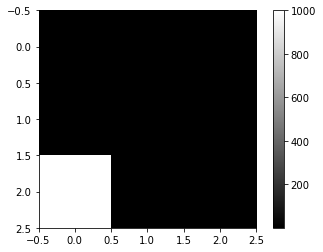

In [3]:
simple_image = [[1.,2.,1.3],
                [1.9,2.3,1.8],
                [1000,2.1,1.4]]
plt.imshow(simple_image, cmap='gray')
# To see what color represents what value, add a colorbar: 
plt.colorbar()

What if we want to see the variation in pixel value of the pixels with values 1-3? We can ask imshow to plot all pixels brighter than 3 as white and all pixels fainter than 1 as black. This way, only the pixel values between 1 and 3 will need to be assigned colours black to white with an even gradient.  

`plt.colorbar` adds the colorbar on the right hand side.

Notice in the image shown below, the colorbar now only shows colors for numbers between 1 and 3. 
Any value smaller than one will be black, any value larger than 3 will be white.
E.g. Notice below the top left pixel value is 1, and it is black and the bottom left pixel value is 1000 and it is white. 

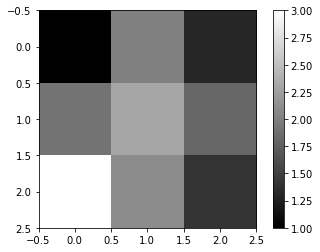

In [4]:
simple_image = [[1.,  2., 1.3],
                [1.9, 2.3,1.8],
                [1000,2.1,1.4]]

plt.imshow(simple_image,vmin=1, vmax=3, cmap='gray')
plt.colorbar()

## Exercises / Questions

Try plotting the below image and setting your own vmax and vmin so that you see the following displayed for the simple_image defined below.
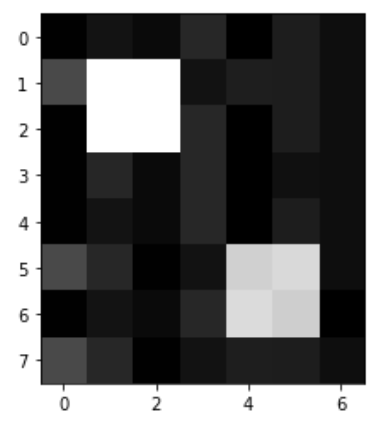

Also try plotting the image with a different cmap, which defines what the color to display the image. 

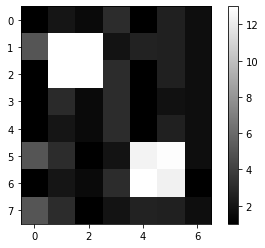

In [5]:
# You can do your exercise in this cell, as well as make extra cells. 

simple_image = [[1., 2., 1.5, 3.1, 0.9, 2.5, 1.7],
                [5., 976, 955, 1.9, 2.6, 2.5, 1.7 ],
                [1., 999, 985, 3.1, 0.9, 2.5, 1.7],
                [1., 3, 1.5, 3.1, 0.9, 1.8, 1.7],
                [1., 2., 1.5, 3.1, 0.9, 2.5, 1.7],
                [5., 3.1, 1., 1.9, 12.4, 12.9, 1.7],
                [1., 2., 1.5, 3.1, 13., 12.3, 0.9],
                [5., 3.1, 1., 1.9, 2.6, 2.5, 1.7]
               ]

plt.imshow(simple_image,vmin=1, vmax=13, cmap='gray')
plt.colorbar()

# Exercise: Add your code here such that you display your image so it looks like the example above

In [5]:
# You can do your exercise in this cell, as well as make extra cells. 

simple_image = [[1., 2., 1.5, 3.1, 0.9, 2.5, 1.7],
                [5., 976, 955, 1.9, 2.6, 2.5, 1.7 ],
                [1., 999, 985, 3.1, 0.9, 2.5, 1.7],
                [1., 3, 1.5, 3.1, 0.9, 1.8, 1.7],
                [1., 2., 1.5, 3.1, 0.9, 2.5, 1.7],
                [5., 3.1, 1., 1.9, 12.4, 12.9, 1.7],
                [1., 2., 1.5, 3.1, 13., 12.3, 0.9],
                [5., 3.1, 1., 1.9, 2.6, 2.5, 1.7]
               ]

# Exercise: Add your code here such that it displays your image with a different color map. 
# Note you can find out more about matplotlib color maps here: https://matplotlib.org/stable/tutorials/colors/colormaps.html

There is a function that helps you set reasonable vmin and vmax values for any input image. It's called a zscale.

The zscale algorithm is designed to display the image values near the _median image value_ without the time consuming process of computing a full image histogram. This is particularly useful for astronomical images which generally have a very peaked histogram corresponding to the background sky in direct imaging or the continuum in a two dimensional spectrum.

Here is an example of how to use it. 

vmin:  0.9
vmax:  8.613069828722004


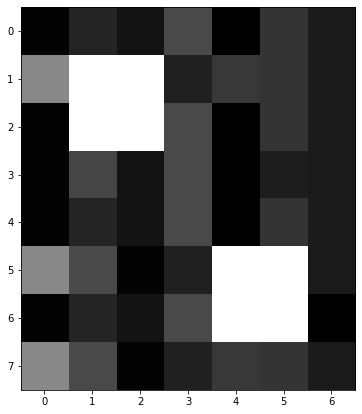

In [7]:
simple_image = [[1., 2., 1.5, 3.1, 0.9, 2.5, 1.7],
                [5., 976, 955, 1.9, 2.6, 2.5, 1.7 ],
                [1., 999, 985, 3.1, 0.9, 2.5, 1.7],
                [1., 3, 1.5, 3.1, 0.9, 1.8, 1.7],
                [1., 2., 1.5, 3.1, 0.9, 2.5, 1.7],
                [5., 3.1, 1., 1.9, 12.4, 12.9, 1.7],
                [1., 2., 1.5, 3.1, 13., 12.3, 0.9],
                [5., 3.1, 1., 1.9, 2.6, 2.5, 1.7]
               ]

interval = ZScaleInterval()
vmin     = interval.get_limits(simple_image)[0]
vmax     = interval.get_limits(simple_image)[1]
print('vmin: ',vmin)
print('vmax: ',vmax)

plt.figure(figsize=(6,11))
plt.imshow(simple_image, vmin=vmin, vmax=vmax, cmap='gray')
# Exercise: Use this automatically determined vmin and vmax to display your image. 

# 2. Read in a fits image from dataset and display it in Python
First let's mount our GDrive: 

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Now that we've connected our Colab notebook to GDrive, we can set up some parameters that contain both the path to our data and the filename of one of the exposures we downloaded in the previous notebook.

Check out your GDrive directory and choose one of the V-filter files you downloaded and copy the filename.

This can be done by either accessing your GDrive 📁LCO via the Drive browser or via the directory tree accessible in the sidebar to the left.

Note: You can always find the path to your .fits file by clicking the three dots next to the file (highlighted by the <font color='magenta'>pink</font> box) and selecting "Copy Path to File":

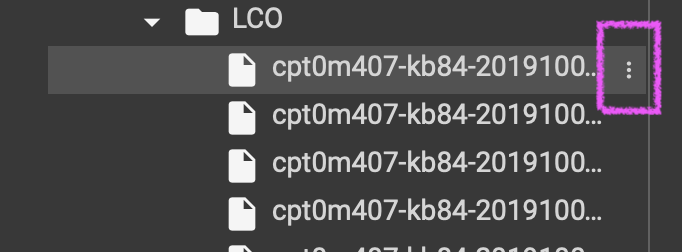

Next we're going to set the path to our mounted LCO directory and select one of the data files we downloaded to Drive in the "Get Data" notebook.

In [ ]:
mypath = 'mypath'
myfile = 'myfile'

Then open the fits file for the single image and display it. Notice in the `plt.imshow` line below, we set `origin='lower'`. This puts 0,0 in the bottom left instead of 0,0 in the top left as is the default (you can see in the above that 0,0 is in the top left.

vmin:  1.9025332
vmax:  154.994501295431


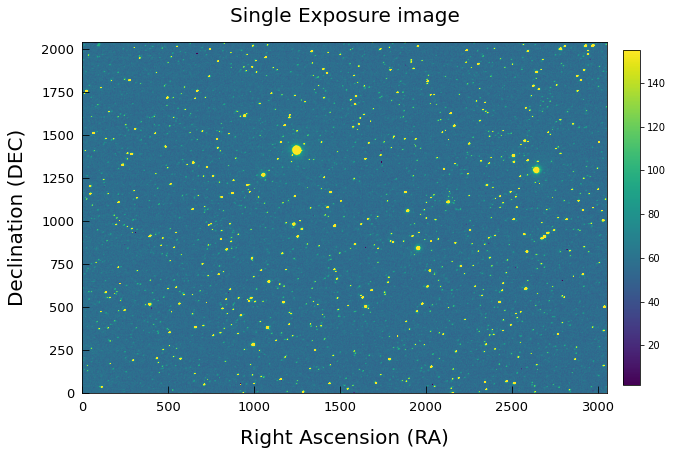

In [5]:
# Plot the whole image with the reference star and target star marked to see if it all looks ok
mypath='Data'
myfile='coj0m403-kb23-20220912-0084-e91.fits.fz'

# Read in the data and the fits file header information
sci_data, sci_header   = fits.getdata(mypath+myfile,header=True)

# Get the best vmin and vmax to visualize the image
# See why these two values were picked using ds9. 
interval = ZScaleInterval()
vmin     = interval.get_limits(sci_data)[0]
vmax     = interval.get_limits(sci_data)[1]
print('vmin: ',vmin)
print('vmax: ',vmax)

# Plotting
figure = plt.figure(figsize=(10,22))     # This sets the figure (image) size, and is larger than default.
im = plt.imshow(sci_data, vmin=vmin, vmax=vmax, origin='lower')
plt.title('Single Exposure image', fontsize=20, pad=20)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
plt.xlabel('Right Ascension (RA)', fontsize=20, labelpad=15)
plt.ylabel('Declination (DEC)', fontsize=20, labelpad=15)
plt.tick_params(which='major', length=7, direction='in', pad=8)
plt.colorbar(im,fraction=0.03, pad=0.03) # This sets the colorbar size and position. 
plt.savefig(mypath+'SEI'+'.png', overwrite=True)

# 3. Calculate the background for the whole image and subtract it.

Even if no visible astronomical objects are present in given part of the sky, there always is some low luminosity present (known as the _sky background_) due mostly to light diffusion from the atmosphere. This includes the diffusion of both incoming light from nearby sources and of man-made Earth sources like cities. This sky background also changes over time, so it needs to be subtracted off any data images before they undergo photometry of the target. A background frame is first calculated and then subtracted from the actual observation result, leaving (in theory) only the incoming light from the astronomical object being observed.

Here, we will estimate the background of every pixel in the image, then subtract it from the image to get a background subtracted image with which we can measure the brightness of stars. To estimate the background we will use a software called `Source Extractor`. You can learn more about this software [here](https://sextractor.readthedocs.io/en/latest/Introduction.html).

In [9]:
# Sigma clip bright obvious things to avoid biasing the background estimate
sigma_clip    = SigmaClip(sigma=3.) 

# Apply the SExtractor algorithm to our estimation
bkg_estimator = SExtractorBackground() 
bkg           = Background2D(   sci_data, (50, 50),
                                filter_size=(3, 3),
                                sigma_clip=sigma_clip,
                                bkg_estimator=bkg_estimator )

# Now let's subtract the background from the data
# The background that Source Extractor calculated is stored in the variable bkg.background. 
sci_bkg = sci_data - bkg.background

## Exercise / Question

Display the background image found above, i.e. bkg.background. You can use what you learned about displaying images in the "1. Tutorial on plotting images" above. Just like the fits image displayed above, put the origin of your image in the lower left. 

vmin:  55.544364244632916
vmax:  59.614821161395625


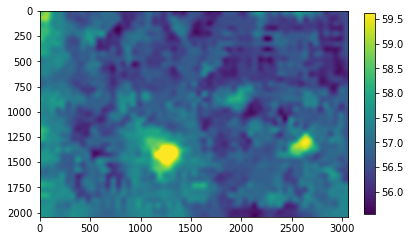

In [45]:
#YOUR CODE HERE
interval = ZScaleInterval()
vmin     = interval.get_limits(bkg.background)[0]
vmax     = interval.get_limits(bkg.background)[1]
print('vmin: ',vmin)
print('vmax: ',vmax)

plt.imshow(bkg.background, vmin=vmin, vmax=vmax)
plt.colorbar(fraction=0.03)

# Exercise / Question

Play around a little with the `sigma` value set in SigmaClip in the `Sextractor` cell above. What do you think this parameter controls/determines? 

❕Remember to set this `sigma` value back to 3.0 before continuing on.

## Exercise / Question
Show the background subtracted image and see what it looks like. Can you tell that it's been background subtracted? Does it look different to the original image?

vmin:  -54.34772426829524
vmax:  98.26814153155995


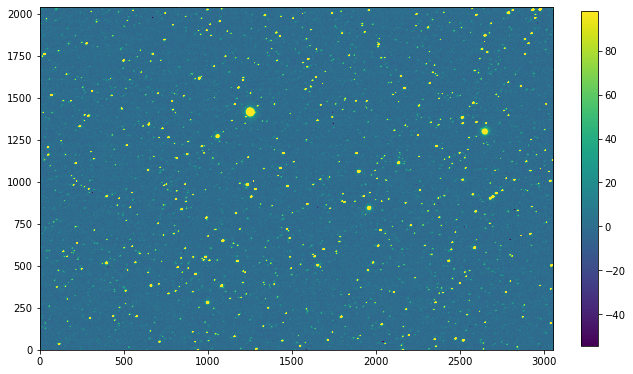

In [16]:
# Show the background subtracted image 
interval = ZScaleInterval()
vmin     = interval.get_limits(sci_bkg)[0]
vmax     = interval.get_limits(sci_bkg)[1]
print('vmin: ',vmin)
print('vmax: ',vmax)

plt.figure(figsize=(10,22))
plt.imshow(sci_bkg, vmin=vmin, vmax=vmax, origin='lower')
plt.colorbar(fraction=0.03)

# 4. Pick out the target and reference stars

As you learned in the _Introduction to Photometry_ tutorial, to do photometry, you need to determine a zeropoint that needs to be added to the uncalibrated magnitude of stars in your image to turn them into _calibrated_ magnitudes. Calibrated magnitudes are useful as they directly relate to physical flux units (where flux is measured in energy per second per collecting area). 

E.g. 
1. You add up the pixel values in background subtracted image of the reference star, let this be counts_ccd_ref = 10,000
2. you turn this into uncalibrated magnitude, m_uncalibrated_ref = -2.5*log10(counts_ccd_ref) = -10
3. Since this is a reference star, others have measured the calibrated magnitude, let's say it is m_calibrated_ref = 17
4. then your zerpoint, zp = m_calibrated_ref - m_uncalibrated_ref = 17 - (-10) = 27. 
5. You can now find the calibrated magnitude of any star that you count up the pixel values for. 
6. Say counts_ccd_MYSTAR = 1000
7. m_uncalibrated_MYSTAR = -2.5*log10(counts_ccd_MYSTAR) = -7.5
8. m_calibrated_MYSTAR = m_uncalibrated_MYSTAR + zp = -7.5 + 27 = 19.5

We will use a series of reference stars to calculate the zeropoint (we will find zeropoints for all of them and use the median as our zeropoint). The best quality reference stars are bright stars that are not saturated. 



Now we will be loading in the reference star lists using `pandas`. Recall that you learned about how to use `pandas` in the PASEA-ARP Python Workshop. 

## Exercise / Question

Load in your reference star list.

Note: It's best to use the `pandas.set_option('display.max_rows', None)` option.

In [17]:
#Your code here
import pandas as pd
ref_star = pd.read_csv('Data/TargetA_reflist.csv')
ref_star
#f

,radeg,"raerr("")",decdeg,"decerr("")",Johnson_V,Verr,Johnson_B,Berr,R(deg)
0,299.235864,0.362,-1.208262,0.147,8.634,0.014,9.939,0.127,0.194
1,299.164421,0.510,-1.098525,0.121,10.122,0.107,10.705,0.048,0.080
2,299.233458,0.501,-0.955927,0.085,10.364,0.086,11.794,0.044,0.081
3,299.076430,0.370,-0.945250,0.208,11.194,0.089,12.372,0.039,0.133
4,299.206894,0.375,-1.126769,0.140,11.438,0.099,12.119,0.056,0.108
5,299.199018,0.497,-1.089140,0.111,11.444,0.096,13.211,0.054,0.069
6,299.172559,0.539,-1.213148,0.245,12.156,0.089,12.724,0.024,0.192
7,299.347536,0.429,-1.231549,0.604,12.297,0.128,14.019,0.050,0.265
8,299.134648,0.142,-0.960250,0.084,12.332,0.091,13.644,0.042,0.080
9,299.216709,0.320,-1.017877,0.137,13.194,0.099,13.815,0.058,0.031


Now let's load in the RA of Dec of the target.

In [6]:
# Target star RA and DEC. This is where you enter the RA and Dec coordinates of your target star. We want to try and find the magnitude of this star.
target_RA  = 299.18555
target_DEC = -1.0214

The next step will be to select between 5-8 reference stars from the list above. Enter their values in the lists below:

In [7]:
# Useful reference stars are ones which are bright, but not saturated, and stars which lie within the field of view. 

#-------------------------------------------------------------------
# TO DO: From the list above, choose 5-8 reference stars.
#-------------------------------------------------------------------
# Construct Python lists for the RA and Dec coordinate values for the stars you've selected from the list above. 
# The list mag_calibrated_ref should be defined by a Python list of the relevant magnitudes (make sure to check what filter was used to capture this frame!) for your chosen reference stars.
# This subset of stars was selected from the APASS DR20 catalog which can be accessed here: 
# https://www.aavso.org/apass-dr10-download

ref_ra             = [299.235864, 299.164421, 299.233458, 299.076430, 299.206894, 299.199018, 299.172559]
ref_dec            = [-1.208262, -1.098525, -0.955927, -0.945250 , -1.126769, -1.089140, -1.213148]
mag_calibrated_ref = [8.634, 10.122, 10.364, 11.194, 11.438, 11.444, 12.156]

# ref_ra             = [299.134648, 299.216709, 299.223853, 298.986162, 299.186903, 299.347536]
# ref_dec            = [-0.960250, -1.017877, -0.941202, -0.784590, -1.045935, -1.231549]
# mag_calibrated_ref = [12.332, 13.194, 13.790, 14.107, 15.158, 12.297]

## Let's visualise where on the image our target and reference stars are located in this frame.
To do this, we have to mark circles where the target and reference stars are. We have to know the x,y position in pixel coordinates for this image, and not just the RA and DEC. To get the x,y pixel coordinates, we use `AstroPy` and  the World Coordinate System information in the header of the fits image to convert RA/DEC to x,y pixels. 

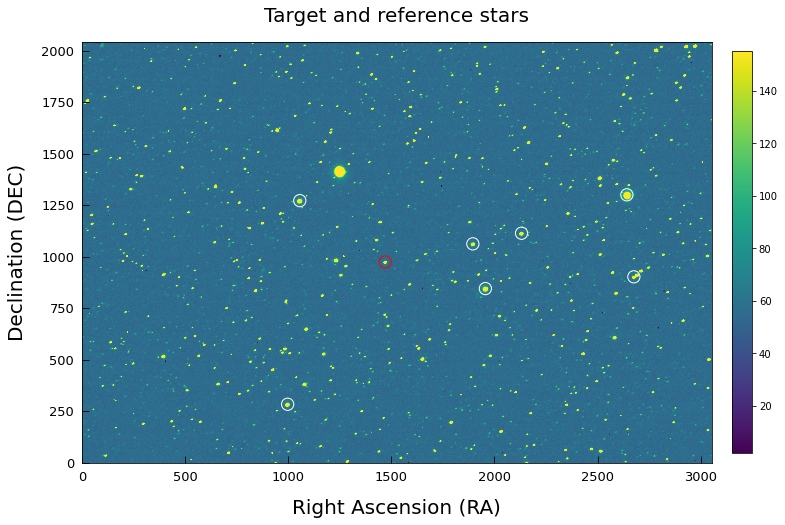

In [11]:
# Plot the whole image (background subtracted version) with the reference star and target star marked to see if it all looks ok

# Read in the data and the fits file header information
sci_data, sci_header   = fits.getdata(mypath+myfile,header=True)

# Get the World Coordinate System (WCS) from the fits header. 
w                            = wcs.WCS(sci_header)

# Convert RA and DEC to x,y pixel coordinate for ref and target stars using the WCS. 
xcoord_ref, ycoord_ref       = w.all_world2pix(ref_ra,ref_dec,1)
xcoord_target, ycoord_target = w.all_world2pix([target_RA],[target_DEC],1)

# Get the best vmin and vmax to visualize the image
interval = ZScaleInterval()
vmin     = interval.get_limits(sci_bkg)[0]
vmax     = interval.get_limits(sci_bkg)[1]

# Plot the figure
figure = plt.figure(figsize=(12,24))
plt.imshow(sci_bkg, vmin=vmin, vmax=vmax, origin='lower')
plt.title('Target and reference stars', fontsize=20, pad=20)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
plt.xlabel('Right Ascension (RA)', fontsize=20, labelpad=15)
plt.ylabel('Declination (DEC)', fontsize=20, labelpad=15)
plt.tick_params(which='major', length=7, direction='in', pad=8)
plt.colorbar(im,fraction=0.03, pad=0.03) # This sets the colorbar size and position. 
plt.savefig(mypath+'refstar'+'.png', overwrite=True)

# Mark with a red circle the target stars. 
plt.scatter(xcoord_target,ycoord_target,marker='o',
            facecolors='none',s=150,linewidth=1,color='red')

# Mark with white circles the reference stars. 
plt.scatter(xcoord_ref,ycoord_ref,marker='o',
            facecolors='none',s=150,linewidth=1,color='white')

Reflect on what you see in the figure above. Are you satisfied with your reference star choices? Take this moment to make any modifications to your reference star lists now before proceeding to the next section.

---
# 5. Put it all together: Do Aperture Photometry

This is where the photometry actually happens! 

*Important Note: All the steps are listed here from start to end. While it will include some repeated steps, this represents the FULL data analysis procedure in it's entirety.

## A useful function
A function that outputs the uncalibrated magnitude of a source, and its error. The inputs to the function are the background subtracted science image "data", the fits header "hdr", the error image "err" that you get from determining the background and the RA (`ra`) and DEC (`dec`) of the object you want to measure photometry to. 

You will be using this function to do photometry, so load it in!

In [21]:
def do_phot_get_mag(data,hdr,err,ra,dec):

    # Get the WCS from the input header or "hdr"
    w         = wcs.WCS(hdr)
    
    # Calculate the x,y pixel coordinates given the RA and DEC input
    xcoords, ycoords = w.all_world2pix(ra,dec,1)
    # Get it in the required format
    positions = np.transpose((xcoords, ycoords))
    
    # Set the aperture inside which to add up the pixel values
    apertures = CircularAperture(positions, r=24.)
    # Perform the photometry given the image, the apertures and the error image. 
    phot      = aperture_photometry(data, apertures, error=err)

    # calculate the uncalibrated magnitude of the sources
    mag     = list(-2.5*np.log10(phot['aperture_sum']) )
    # calculate the error of the uncalibrated magnitudes
    mag_err = list((2.5/np.log(10))*(phot['aperture_sum_err']/phot['aperture_sum']))
    
    return mag,mag_err

### a. Open the frame and read out the data, header, and time of observation

In [22]:
# Read in file
sci_data, sci_header   = fits.getdata(mypath+myfile,header=True)

# The "header" of fits files contains a lot of information on the image.

# Grab the time of observation of this image.
mjd      = sci_header['MJD-OBS']
datetime = sci_header['DATE']

# print RA and DEC in header, which tells you where the telescope was pointing when this image was taken.
print('RA:',sci_header['RA'])
print('DEC:',sci_header['DEC'])

RA: 19:56:46.3387
DEC: -01:01:50.423


In [23]:
# print the whole header to have a look
print('\nEntire header:')
sci_header


Entire header:


SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 3054                                                  
NAXIS2  =                 2042                                                  
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
XTENSION= 'BINTABLE'           / binary table extension                         
ZDITHER0=                 3484 / dithering offset when quantizing floats        
DATADICV= 'LCOGT-DIC.FITS-0.11.0' / Version number of the data dictionary       
HDRVER  = 'LCOGT-HDR-1.4.0'    / Version number of the headers                  
ORIGIN  = 'LCOGT   '           / Organization responsible for the data          
SITEID  = 'coj     '        

### Exercise / Question

Print out the time the image was taken and the location. How does this time relate to your requested set of observations?

In [24]:
# Print the time and location of observation of this exposure
print(sci_header['UTSTART'])
print(sci_header['UTSTOP'])
print(sci_header['site'])

10:01:50.719
10:03:20.955
LCOGT node at Siding Spring Observatory


### b. Get the background of the image and subtract it; Calculate the error associated with the background.

Note: The error is calculated by adding the rms error of the background and the background subtracted science image together. 

In [25]:
# Background estimation:
sigma_clip = SigmaClip(sigma=3.) # Sigma clip bright obvious things to avoid biasing the background estimate
bkg_estimator = SExtractorBackground() # Apply the SExtractor algorithm to our estimation
bkg = Background2D(
    sci_data.data, (50, 50),
    filter_size=(3, 3),
    sigma_clip=sigma_clip,
    bkg_estimator=bkg_estimator)

# Now let's subtract the background from the data
sci_bkg = sci_data.data - bkg.background

# Define an error image that will be used when calculating photometry
effective_gain = 1.
error = calc_total_error(sci_bkg, bkg.background_rms, effective_gain)

### c. For the target star and each reference star, carry out photometry. 

Note: Remember to ensure you are using the _background subtracted_ image. This step should output an error of the photometry measurement. 

In [27]:
target_RA  = 299.18555
target_DEC = -1.0214

# Useful reference stars are ones which are bright, but not saturated, and stars which lie within the field of view. 

#-------------------------------------------------------------------
# TO DO: From the list above, choose 5-8 reference stars.
#-------------------------------------------------------------------
# Construct Python lists for the RA and Dec coordinate values for the stars you've selected from the list displayed in pandas above. 
# The list mag_calibrated_ref should be defined by a Python list of the relevant magnitudes (make sure to check what filter was used to capture this frame!) for your chosen reference stars.
# This subset of stars was selected from the APASS DR20 catalog which can be accessed here: 
# https://www.aavso.org/apass-dr10-download

ref_ra             = [299.235864, 299.164421, 299.233458, 299.076430, 299.206894, 299.199018, 299.172559]
ref_dec            = [-1.208262, -1.098525, -0.955927, -0.945250 , -1.126769, -1.089140, -1.213148]
mag_calibrated_ref = [8.634, 10.122, 10.364, 11.194, 11.438, 11.444, 12.156]

# ref_ra             = [299.134648, 299.216709, 299.223853, 298.986162, 299.186903]
# ref_dec            = [-0.960250, -1.017877, -0.941202, -0.784590, -1.045935]
# mag_calibrated_ref = [12.332, 13.194, 13.790, 14.107, 15.158]

# Calculate instrumental mags for each of the reference stars
mag_uncalibrated_refs,mag_uncalibrated_refs_err     = do_phot_get_mag(sci_bkg,sci_header,error,ref_ra,ref_dec)

# Do photometry on the variable target
mag_uncalibrated_target,mag_uncalibrated_target_err = do_phot_get_mag(sci_bkg,sci_header,error,target_RA,target_DEC)

print('The error in the calibrated magnitude for the target is: \n',mag_uncalibrated_target_err)

The error in the calibrated magnitude for the target is: 
 [0.00438536809101352]


### d. Find the magnitude offset between the reference stars and the catalog magnitudes (i.e. the zeropoint) and calculate the magnitude of the target star, and its error. 

In [28]:
# Calculate the zeropoint
offsets = mag_calibrated_ref - np.array(mag_uncalibrated_refs)

# Print the offset values
print('These are the offsets between m_uncalibrated_ref and m_calibrated_ref: \n',offsets)

# Calculate the zeropoint using a median function
zeropoint     = np.median(offsets)
zeropoint_err = np.std(offsets)
print(f'\nThe zeropoint and zeropoint error is: {zeropoint:.3f}, {zeropoint_err:.2f}')

These are the offsets between m_uncalibrated_ref and m_calibrated_ref: 
 [25.77918534 26.03571889 26.03130449 26.00367821 26.02455054 26.05062494
 26.86912472]

The zeropoint and zeropoint error is: 26.031, 0.32


Finally, we will calculate a magntitude (with error) for our target star in this frame! 

In [29]:
# Calculate the calibrated magnitude of the target star and it's error

mag_calibrated_target     = mag_uncalibrated_target[0]+zeropoint
mag_calibrated_target_err = mag_uncalibrated_target_err[0] + zeropoint_err

12.83675077692527

## Exercise / Question

In [30]:
# Print the magnitude and magnitude error of your target.
mag_calibrated_target

12.775287718077053

# 6. Create a cutout image around the target star


The procedure below allows us to create a little cutout of our target star.

We can first define the relevant function:

In [31]:
# A function that outputs a small cutout of an image given a big image. 

def make_cutout(data,hdr,ra,dec):

    w = wcs.WCS(hdr)
    xcoord, ycoord = w.all_world2pix(ra,dec,1)
    position = np.transpose((xcoord, ycoord))
    size = u.Quantity([120, 120], u.pixel)
    cutout = Cutout2D(data, position, size, wcs=w, mode='strict')

    cutout_wcs = cutout.wcs
    header = cutout_wcs.to_header()
    hdu = fits.PrimaryHDU(data=cutout.data, header=header)

    return hdu

Then we can plot it out and save this image as a new file named `cutout.png`.

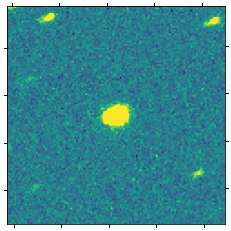

In [32]:
# Make tiny cutouts of the variable star in each frame
cutout_hdu = make_cutout(sci_bkg,sci_header,target_RA,target_DEC)

# Plot figures using these cutouts and output images
interval = ZScaleInterval()
vmin = interval.get_limits(cutout_hdu.data)[0]
vmax = interval.get_limits(cutout_hdu.data)[1]

plt.subplot(projection=wcs.WCS(cutout_hdu.header))
plt.imshow(cutout_hdu.data, vmin=vmin, vmax=vmax, origin='lower')
plt.xlabel('R.A.')
plt.ylabel('Declination')

# Save the small cutout as a png, with the file name as the time of observation. 
# This can be used later to make a movie of your source
pngname = 'cutout'
plt.savefig(mypath+pngname+'.png', overwrite=True)

# Final Exercise

Select some other star (different from your target star and not one you have used as a reference star!) as your target star, and calculate the calibrated magnitude of that star in this exposure.